In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

import torchvision.transforms as transforms
from torch.autograd import Variable

from PIL import Image
import scipy.misc

import torch.utils.data
import torchvision.datasets as datasets

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
class GramMatrix(nn.Module):
    
    def forward(self, input):
        a, b, c, d = input.size()
        features = input.view(a * b, c * d)
        G = torch.mm(features, features.t())
        
        return G.div(a * b * c * d)

In [4]:
class StyleCNN(object):
    
    def __init__(self, style, content, pastiche):
        super(StyleCNN, self).__init__()
        
        self.style = style
        self.content = content
        self.pastiche = nn.Parameter(pastiche)
        
        self.content_layers = ['conv_4']
        self.style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
        self.content_weight = 1
        self.style_weight = 1000
        
        self.loss_network = models.vgg19(pretrained=True)
        
        self.gram = GramMatrix()
        self.loss = nn.MSELoss()
        self.optimizer = optim.LBFGS([self.pastiche])
        
        self.use_cuda = torch.cuda.is_available()
        if self.use_cuda:
            self.loss_network.cuda()
            self.gram.cuda()
            
    def train(self):
        def closure():
            self.optimizer.zero_grad()
          
            pastiche = self.pastiche.clone()
            #pastiche.clamp_(0, 1)
            content = self.content.clone()
            style = self.style.clone()
            
            content_loss = 0
            style_loss = 0
            
            i = 1
            not_inplace = lambda layer: nn.ReLU(inplace=False) if isinstance(layer, nn.ReLU) else layer
            for layer in list(self.loss_network.features):
                layer = not_inplace(layer)
                if self.use_cuda:
                    layer.cuda()
                    
                pastiche, content, style = layer.forward(pastiche), layer.forward(content), layer.forward(style)
                
                if isinstance(layer, nn.Conv2d):
                    name = "conv_" + str(i)
                    
                    if name in self.content_layers:
                        content_loss += self.loss(pastiche * self.content_weight, content.detach() * self.content_weight)
                    
                    if name in self.style_layers:
                        pastiche_g, style_g = self.gram.forward(pastiche), self.gram.forward(style)
                        style_loss += self.loss(pastiche_g * self.style_weight, style_g.detach() * self.style_weight)
                
                if isinstance(layer, nn.ReLU):
                    i += 1
            
            total_loss = content_loss + style_loss
            total_loss.backward()
            
            return total_loss
    
        self.optimizer.step(closure)
        return self.pastiche

In [5]:
imsize = 256

loader = transforms.Compose([
             transforms.Scale(imsize),
             transforms.ToTensor()
         ])

unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name)
    image = Variable(loader(image))
    image = image.unsqueeze(0)
    return image
  
def save_image(input, path):
    image = input.clone().cpu()
    image = image.view(3, imsize, imsize)
    image = unloader(image)
    #scipy.misc.imsave(path, image)

/opt/conda/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [6]:
# CUDA Configurations
dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

# Content and style
style = image_loader("styles/picasso.jpg").type(dtype)
content = image_loader("contents/dancing.jpg").type(dtype)

pastiche = image_loader("contents/dancing.jpg").type(dtype)
print(type(pastiche))
pastiche = torch.randn(content.size()).type(dtype)

num_epochs = 31

def main(style, content, pastiche):
    style_cnn = StyleCNN(style, content, pastiche)
    
    for i in range(num_epochs):
        pastiche = style_cnn.train()
    
        if i % 10 == 0:
            print("Iteration: %d" % (i))
            
            path = "outputs/%d.png" % (i)
            #pastiche.clamp_(0, 1)
            save_image(pastiche, path)

main(style, content, pastiche)

<class 'torch.Tensor'>
Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30


In [7]:
style.size()

torch.Size([1, 3, 256, 256])

In [21]:
import matplotlib.pyplot as plt
import numpy as np
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
#     image = (image + 1) / 2
#     image[image < 0] = 0
#     image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [22]:
print(pastiche[0].size())

torch.Size([3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


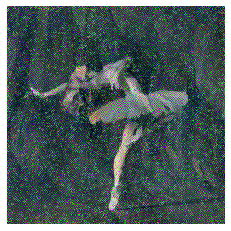

In [23]:
myimshow(pastiche[0])